<a href="https://colab.research.google.com/github/WestChaeVI/CNN-models/blob/main/models/GoogLeNet(91_5%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/CV_seminar_project/

/content/drive/MyDrive/CV_seminar_project


In [2]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

In [3]:
import torch.nn as nn

# 하이퍼파라미터
batch_size = 8
lr = 0.0001
epochs = 100
optimizer_name = 'adam'

model_name = 'GoogLeNet'
criterion = nn.CrossEntropyLoss().to(device) # cost function 패널티 주는 역할

root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
valid_path = '/content/drive/MyDrive/CV_seminar_project/valid'

In [4]:
from cv_dataset import Custom_dataset as C
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224), # 
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2() # 텐서화만 적용 , pytorch albumentation의 totensor 는 min_max scaling 적용까지
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0)

# Define Convolution Blocks

## 1x1 Conv

In [5]:
def conv_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

## 1x1 Conv -> 3x3 Conv

In [6]:
def conv_1_3(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,3,1,1),
        nn.ReLU()
    )
    return model

## 1x1 Conv -> 5x5 Conv

In [7]:
def conv_1_5(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,5,1,2),
        nn.ReLU()
    )
    return model

## 3x3 MaxP -> 1x1 Conv

In [8]:
def max_3_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

# Define Inception Module

Inception 모듈은 이전 단계에서 정의한 함수들을 활용해서 concat해주는 단계입니다.

+ 1x1 Convolution
+ 1x1 Convolution -> 3x3 Convolution
+ 1x1 Convolution -> 5x5 Convolution
+ 3x3 MaxPooling -> 1x1 Convolution

In [9]:
class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)
        return output

# Define GoogLeNet 

In [10]:
class GoogLeNet(nn.Module):
    def __init__(self, base_dim, num_classes=3):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3), # [8, 64, 224,224]
            nn.MaxPool2d(3,2,1),
            nn.Conv2d(base_dim,base_dim*3,3,1,1),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3,64,96,128,16,32,32),
            inception_module(base_dim*4,128,128,192,32,96,64),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480,192,96,208,16,48,64),
            inception_module(512,160,112,224,24,64,64),
            inception_module(512,128,128,256,24,64,64),
            inception_module(512,112,144,288,32,64,64),
            inception_module(528,256,160,320,32,128,128),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832,256,160,320,32,128,128),
            inception_module(832,384,192,384,48,128,128), 
            nn.AvgPool2d(7,1),
        )
        self.layer_5 = nn.Dropout2d(0.4)
        self.fc_layer = nn.Linear(1024,self.num_classes)
                
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [11]:
from torchvision import models # model 라이브러리

googlenet = models.googlenet(pretrained = True).to(device)
# fine tuning
googlenet.fc = nn.Linear(googlenet.fc.in_features, 3).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
from torchsummary import summary
summary(googlenet, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [13]:
optimizer = torch.optim.Adam(googlenet.parameters(), lr = lr, weight_decay = 1e-8) # 학습을 할수록 학습률 낮춰주는 역할(러닝 보폭 줄이기, 섬세하게 보기위해)

In [14]:
from tqdm import tqdm
from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter
import argparse
import logging
from pathlib import Path
from torch import optim
import numpy as np

train_acc_lst, train_loss_lst, test_acc_lst, test_loss_lst= [], [], [], []

epochs = 100
model = googlenet
model_name = 'GoogLeNet'
state={}

for epoch in range(1, epochs+1):

  train_loss = 0.0
  total = 0
  correct = 0
  train_acc = 0
  
  model.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)

    output = model(train_img) # 모델에 입력

    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화    
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습

    # loss & acc
    train_loss += loss.item()
    _, predictions = torch.max(output.data ,dim = 1)
   
    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += 100 * (correct / total)

  train_loss = round(train_loss/(i+1), 3) # 소수점 반올림
  train_acc = round(train_acc/(i+1), 3)
  print(f'Trainset {epoch}/{epochs} Loss : {train_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(train_loss)

  # -------------------------------------------------------------------------------------
  test_loss = 0.0
  corrects = 0
  totals = 0
  test_acc = 0

  model.eval()
  with torch.no_grad():

    for i, (valid_img, valid_label) in enumerate(valid_loader):
          # gpu에 할당
      valid_img = valid_img.to(device)
      valid_label = valid_label.to(device)

      outputs = model(valid_img) # 모델에 입력
      losses = criterion(outputs, valid_label)

      # loss & acc
      test_loss += losses.item()
      _, predictions = torch.max(outputs.data ,dim = 1 )
    
      totals += valid_label.size(0)
      corrects += (predictions == valid_label).sum().item()
      test_acc += 100 * (corrects / totals)

    test_loss = round(test_loss/(i+1), 3) # 소수점 반올림
    test_acc = round(test_acc/(i+1), 3)
    print(f'Validset {epoch}/{epochs} Loss : {test_loss}, Accuracy : {test_acc}% \n')
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)
  
  # 모델 저장
  if np.max(test_acc_lst) <= test_acc:

    state['epoch'] = epoch
    state['net'] = model.state_dict()

    state['train_loss'] = train_loss
    state['test_loss'] = test_loss

    state['train_acc'] = train_acc
    state['test_acc'] = test_acc
torch.save(state, '/content/drive/MyDrive/CV_seminar_project/GoogLeNet_{}_{}.pth'.format(str(state['epoch']), str(state['test_acc'])))

Trainset 1/100 Loss : 0.897, Accuracy : 49.491%
Validset 1/100 Loss : 0.645, Accuracy : 66.259% 

Trainset 2/100 Loss : 0.628, Accuracy : 77.28%
Validset 2/100 Loss : 0.494, Accuracy : 74.524% 

Trainset 3/100 Loss : 0.554, Accuracy : 76.285%
Validset 3/100 Loss : 0.554, Accuracy : 82.021% 

Trainset 4/100 Loss : 0.478, Accuracy : 81.746%
Validset 4/100 Loss : 0.441, Accuracy : 82.082% 

Trainset 5/100 Loss : 0.434, Accuracy : 81.784%
Validset 5/100 Loss : 0.397, Accuracy : 77.302% 

Trainset 6/100 Loss : 0.403, Accuracy : 81.868%
Validset 6/100 Loss : 0.346, Accuracy : 76.467% 

Trainset 7/100 Loss : 0.394, Accuracy : 85.511%
Validset 7/100 Loss : 0.348, Accuracy : 85.911% 

Trainset 8/100 Loss : 0.339, Accuracy : 90.488%
Validset 8/100 Loss : 0.393, Accuracy : 77.899% 

Trainset 9/100 Loss : 0.374, Accuracy : 82.973%
Validset 9/100 Loss : 0.338, Accuracy : 83.763% 

Trainset 10/100 Loss : 0.319, Accuracy : 88.999%
Validset 10/100 Loss : 0.371, Accuracy : 81.679% 

Trainset 11/100 Los

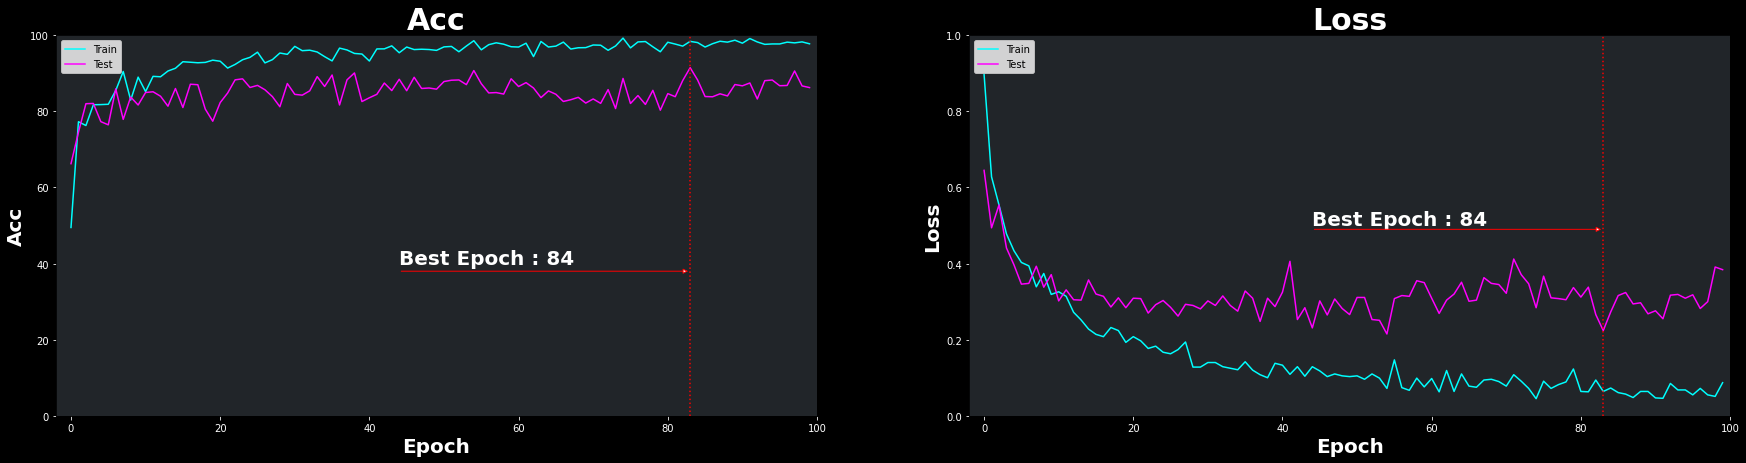

In [24]:
import matplotlib.pyplot as plt
import numpy as np

arrowprops = dict(fc='white', color='red',arrowstyle="-|>")
font1 = {'family': 'serif',
    'color':  'darkred',
    'weight': 'normal',
    'size': 16}
  

fig = plt.figure(figsize=(30,7),facecolor='black')
plt = fig.subplots(1,2)

train_score = {'Acc':train_acc_lst, 'Loss':train_loss_lst}
valid_score = {'Acc':test_acc_lst, 'Loss':test_loss_lst}

for i in range(len(train_score.keys())):
  plt[i].plot(train_score[list(train_score.keys())[i]], c='cyan')
  plt[i].plot(valid_score[list(valid_score.keys())[i]],c='magenta')
  plt[i].set_title(list(valid_score.keys())[i],color='white', fontweight='bold', fontsize=30)
  plt[i].set_ylabel(list(valid_score.keys())[i],color='white', fontweight='bold', fontsize=20)
  plt[i].set_xlabel('Epoch',color='white', fontweight='bold', fontsize=20)
  if i == 0:
    plt[i].set_ylim([0,100])
    plt[i].text(state['epoch']-40,40, "Best Epoch : {}".format(state['epoch']), 
            fontdict= {'color':  'white','weight': 'bold','size': 20})
    plt[i].annotate("",xy=(state['epoch']-1, 38),
                xytext=(state['epoch']-40,38),
                arrowprops=arrowprops)
  else:
    plt[i].set_ylim([0,1])
    plt[i].text(state['epoch']-40,0.5, "Best Epoch : {}".format(state['epoch']), 
            fontdict= {'color':  'white','weight': 'bold','size': 20})
    plt[i].annotate("",xy=(state['epoch']-1, 0.49),
                xytext=(state['epoch']-40,0.49),
                arrowprops=arrowprops)

  plt[i].set_xlim([-2, 100])
  plt[i].legend(['Train', 'Test'], loc='upper left')
  plt[i].axvline(x=state['epoch']-1, color='r', linestyle=':')
  plt[i].tick_params(axis='x', colors='white')
  plt[i].tick_params(axis='y', colors='white')
  plt[i].patch.set_facecolor('#212529')




In [21]:
print('100 epcohs 중 validset 기준 accuracy {} % 성능을 달성하였습니다.'.format(max(test_acc_lst)))

100 epcohs 중 validset 기준 accuracy 91.48 % 성능을 달성하였습니다.


In [22]:
state['epoch']

84